### Quantization of GoogleNet model.

`INT8` quantization to Image Classification model using [Post-training Optimization Tool API](../../compression/api/README.md).


In [1]:
import os
from pathlib import Path
from PIL import Image

import tomopy
import mkl

path = os.getcwd()
mkl.domain_set_num_threads(1, domain='fft')

'success'

In [2]:
import numpy as np
import torch
from addict import Dict

In [3]:
from openvino.tools.pot.api import DataLoader, Metric
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model, save_model
from openvino.tools.pot.graph.model_utils import compress_model_weights
from openvino.tools.pot.pipeline.initializer import create_pipeline
from openvino.runtime import Core

from torchvision import transforms


/home/dwip.dalal/anaconda3/envs/py37/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
# Set the data and model directories
DATA_DIR = 'data'
MODEL_DIR = 'model'

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

### Prepare the Model

- Download a PyTorch model from Torchvision repository
- Convert it to ONNX format
- Run Model Optimizer to convert ONNX to OpenVINO Intermediate Representation (OpenVINO IR)

In [5]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model = torch.load('../model/saved_model/lenet.pt')
model.eval()
dummy_input = torch.randn(1, 3, 224, 224)

onnx_model_path = Path(MODEL_DIR) / 'inception_v3.onnx'
ir_model_xml = onnx_model_path.with_suffix('.xml')
ir_model_bin = onnx_model_path.with_suffix('.bin')

torch.onnx.export(model, dummy_input, onnx_model_path, verbose=True)

# Run Model Optimizer to convert ONNX to OpenVINO IR.
!mo --framework=onnx --data_type=FP16 --input_shape=[1,3,224,224] -m $onnx_model_path  --output_dir $MODEL_DIR

graph(%input.1 : Float(1:150528, 3:50176, 224:224, 224:1, requires_grad=0, device=cpu),
      %538 : Float(64:147, 3:49, 7:7, 7:1, requires_grad=0, device=cpu),
      %539 : Float(64:1, requires_grad=0, device=cpu),
      %541 : Float(64:64, 64:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %542 : Float(64:1, requires_grad=0, device=cpu),
      %544 : Float(192:576, 64:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %545 : Float(192:1, requires_grad=0, device=cpu),
      %547 : Float(64:192, 192:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %548 : Float(64:1, requires_grad=0, device=cpu),
      %550 : Float(96:192, 192:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %551 : Float(96:1, requires_grad=0, device=cpu),
      %553 : Float(128:864, 96:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %554 : Float(128:1, requires_grad=0, device=cpu),
      %556 : Float(16:192, 192:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %557 : Float(16:1, requires_grad=0, device=cpu),
      %559

### Loading dataset

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
s = f'ILSVRC2012_val_00000000'
Image_directory = []
file1 = open('data/ILSVRC2012_devkit_t12/data/val.txt', 'r')
Lines = file1.readlines()
for a in range(1,3001):
    ufd = s[:-len(str(a))]+str(a)+'.JPEG'
    image_path = Path(DATA_DIR) / ufd
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image)
    if len(image.shape) != 3:
        image = np.stack([image] * 3, axis=2)

    image = transform(image)
    Image_directory.append((image, int(Lines[a-1].strip().split(' ')[1])))

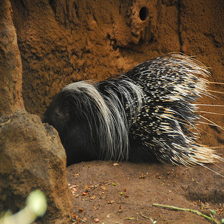

In [7]:
image = Image_directory[20][0]
true = Image_directory[20][1]
image = image.unsqueeze(0)
image_path = 'data/ILSVRC2012_val_00000007.JPEG'
image = Image.open(image_path)
image = image.resize((224, 224))
image

In [8]:
image = np.array(image)
image = transform(image)
image = image.reshape(1,3,224,224)
output = model(image)
output2 = model(dummy_input)

In [9]:
dataset = Image_directory

In [10]:
# Create a DataLoader from a ImageNet dataset.
class ImageNetDataset(DataLoader):

    def __init__(self, config):

        if not isinstance(config, Dict):
            config = Dict(config)
        super().__init__(config)
        self.indexes, self.pictures, self.labels = self.load_data(dataset)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        if index >= len(self):
            raise IndexError

        return (self.indexes[index], self.labels[index]), self.pictures[index].numpy()

    def load_data(self, dataset):

        pictures, labels, indexes = [], [], []
        
        for idx, sample in enumerate(dataset):
            pictures.append(sample[0])
            labels.append(sample[1])
            indexes.append(idx)

        print(pictures[0])
        
        return indexes, pictures, labels

### Run Quantization Pipeline and compare the accuracy of the original and quantized models

In [11]:
model_config = Dict({
    'model_name': 'inception_v3',
    'model': ir_model_xml,
    'weights': ir_model_bin
})
engine_config = Dict({
    'device': 'CPU',
    'stat_requests_number': 2,
    'eval_requests_number': 2
})
dataset_config = {
    'data_source': DATA_DIR
}
algorithms = [
    {
        'name': 'DefaultQuantization',
        'params': {
            'target_device': 'CPU',
            'preset': 'performance',
            'stat_subset_size': 3000
        }
    }
]

model = load_model(model_config)

data_loader = ImageNetDataset(dataset_config)
engine = IEEngine(engine_config, data_loader)
pipeline = create_pipeline(algorithms, engine)
compressed_model = pipeline.run(model)
compress_model_weights(compressed_model)


compressed_model_paths = save_model(model=compressed_model,
                                    save_path=MODEL_DIR, model_name="quantized_inception_v3_sl2")
compressed_model_xml = compressed_model_paths[0]["model"]
compressed_model_bin = Path(compressed_model_paths[0]["model"]).with_suffix(".bin")

tensor([[[0.8961, 0.9474, 0.9817,  ..., 1.1187, 1.0844, 1.0502],
         [0.9303, 0.9817, 1.0159,  ..., 1.1015, 1.0673, 1.0673],
         [0.9303, 0.9988, 1.0159,  ..., 1.0844, 1.0673, 1.0331],
         ...,
         [0.6563, 0.7248, 0.8276,  ..., 0.8961, 0.9817, 0.8447],
         [0.6734, 0.6392, 0.7419,  ..., 0.8789, 0.7933, 0.7248],
         [0.6221, 0.7762, 0.7933,  ..., 0.6392, 0.7591, 0.8104]],

        [[1.2206, 1.2731, 1.3081,  ..., 1.4657, 1.4482, 1.4307],
         [1.2731, 1.3081, 1.3256,  ..., 1.4307, 1.3957, 1.4132],
         [1.2906, 1.3256, 1.3256,  ..., 1.4132, 1.3957, 1.3606],
         ...,
         [0.8179, 0.9405, 1.0630,  ..., 1.1155, 1.2206, 1.0805],
         [0.8529, 0.8529, 0.9405,  ..., 1.0805, 0.9930, 0.8880],
         [0.8354, 0.9580, 0.9755,  ..., 0.8354, 0.9580, 0.9930]],

        [[1.4722, 1.5245, 1.5594,  ..., 1.6988, 1.6640, 1.6291],
         [1.5071, 1.5594, 1.5768,  ..., 1.6640, 1.6291, 1.6465],
         [1.5071, 1.5594, 1.5594,  ..., 1.6291, 1.5942, 1.

In [12]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m $ir_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.1.0-7019-cdb9bec7210-releases/2022/1
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.1
         Build................... 2022.1.0-7019-cdb9bec7210-releases/2022/1

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

In [13]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $compressed_model_xml -d CPU -api async

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.1.0-7019-cdb9bec7210-releases/2022/1
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.1
         Build................... 2022.1.0-7019-cdb9bec7210-releases/2022/1

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 